# EXPLORATORY DATA ANALYSIS - RÉSUMÉ

**Analyse de la forme:**
- **variable target :** SARS-Cov-2 exam result
- **lignes et colonnes :** (5644, 111)
- **types de variables :** 70 qualitatives, 41 quantitatives
- **analyse des valeurs manquantes :** 
    - beaucoup de NaN (moitié des variables ont >90% de NaN)
    - 2 groupes de données: 76% -> test viral ; 89% -> taux sanguins 

**Analyse du fond:**
- **visualisation de la target  :**
    - 10% de positifs
- **signification des variables :**
    - variables continues : standardisées, skewed (asymétriques), tests sanguin
    - age quantile : difficile d'interpréter ce graphique, clairement ces données ont été traitées. On pourrait penser tranches d'âges de 5 ans, mais cela pourrait aussi être une transformation mathématiques. On ne peut pas savoir car la personne qui a mit ce dataset ne le précise nul part. Mais pas très important.
    - variables qualitatives : binaire, viral ; détection de Rhinovirus/Enterovirus semble très élevée.
- **relations variables / target :**
    - target / blood : les taux de Monocytes, Platelets et Leukocytes semblent liés au covid- -> hypothèse à tester.
    - target / age : les individus de faible age sont très peu contaminés ? Attention on ne connait pas l'age, et on ne sait pas de quand date le dataset (s'il s'agit d'enfants on sait que les enfants sont touchés autant que les adultes). En revanche cette variable pourra être intéressante pour la comparer avec les résultats de tests sanguins.
    - target / viral : les doubles maladies sont très rares. Rhinovirus/Enterovirus positif - covid19 négatif? -> hypothèse à tester? Mais il est possible que la région ait subie une épidémie de ce virus. De plus, on peut très bien avoir deux virus en même temps. Tout ça n'a aucun lien avec le covid19.
    
    
**Conclusions initiales :**
- Beaucoup de données manquantes (au mieux on garde 20% du dataset)
- 2 groupes de données intéressantes (viral, sanguin)
- Presque pas de variable "discriminante" pour distinguer les cas positifs/négatifs, ce qui nous permet de dire qu'il n'est pas vraiment approprié de vouloir prédire si un individu est atteint du COVID-19 en se basant sur ces simples tests sanguins. Pas grave, il faut quand même poursuivre l'analyse pour essayer de voir ce qu'il peut apprendre. Un bon data scientist va jusqu'au bout de sa mission. Si en cours de route on se rend compte que l'histoire n'est pas aussi simple qu'on pouvait espérer, alors il faut pouvoir le démontrer de façon robuste en allant jusqu'au bout des choses (underfitting? overfitting? expliquer ce qu'il se passe).
- Quand même quelque chose de positif : on peut identifier des variables intéressantes qui sont susceptibles de jouer un rôle non négligeable (monocytes etc.).

Pour aller plus loin, on va étudier les relations entre les variables, les NaN, et tester des hypothèses émises précédemment.

- **Relations variables / variables :**
    - **blood_data / blood_data :** certaines variables sont très corrélées (+0.9), à surveiller plus tard.
    - **blood_data / age :** très faible corrélation entre age et taux sanguins.
    - **viral / viral :** Influenza rapid test donne de mauvais résultats, il faudra peut-être la laisser tomber.
    - **maladie / blood_data :** les taux sanguins entre malades et covid-19 sont différents. A tester avec une hypothèse.
    - **hospitalisation / blood :** intéressant dans le cas où on veut prédire dans quelle service un patient devrait aller.
    - **hospitalisation / est malade :** aucune tendance ne se dégage, mis à part le fait que la plupart des personnes placées en suiveillance ne sont pas malades (pas fait dans la vidéo, remarque perso).
    

- **NaN analyse :** valeurs restantes après un dropna:
    - sur tout le dataset: 90
    - groupe viral: 1350 (répartition target 92/8)
    - groupe blood: 600 (répartition target 87/13)

**Hypotheses nulles (H0)**:

Pour chaque hypothèse, on va utiliser un **test de student** qui permet de vérifier si la moyenne entre 2 distributions est significativement différente. Pour cela, on émet une hypothèse nulle dans laquelle on suppose que les moyennes sont égales entre nos 2 distributions. Le principe du test de student est d'essayer de rejeter cette hypothèse nulle. On définit un seuil alpha (généralement autours de 2% ou 5%), on calcule une valeur-p grâce au test, et si la valeur-p est inférieure au seuil de probabilité alpha alors on peut rejeter l'hypothèse nulle (sinon on ne peut pas rejeter l'hypothèse nulle, mais rien de plus).
- Les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativement différents
    - **H0 :** Les taux moyens sont égaux chez les individus positifs et négatifs
    - **Conclusions :** les Platelets, les Leukocytes, les Monocytes (et les Eosinophils) semblent être des variables significativement différentes entre les gens atteints et non atteints du covid-19.

- Les individus atteints d'une quelconque maladie ont des taux sanguins significativement différents.
    - **H0 :** Les taux moyens sont égaux chez les individus malades et non malades
    - **Conclusion :** L'hypothèse nulle ne peut être rejetée.
    
Remarque sur le test d'hypothèse : vu qu'on échantillonne pour avoir des classes équilibrées, on réalise le test plusieurs fois et on utilise la p-value moyenne.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

dataset = pd.read_excel("data/dataset_covid19.xlsx")

In [58]:
df = dataset.copy()

# Pre-processing

## Première étape: Nettoyage
- supprimer :
    - toutes les colonnes avec plus de 90% de valeurs manquantes
    - Patient ID
    - Parainfluenza 2
    - Influenza A/B, rapid test
- creer viral_columns (0.75 - 0.88) et blood_columns (0.88 - 0.9)
- ajout colonne malade
- ajout colonne "statut" pour la prise en charge (et supprimer ¨"Patient addmited to..."

In [59]:
df = df[df.columns[df.isna().sum() / df.shape[0] < 0.9]]
df = df.drop(["Patient ID", "Parainfluenza 2", "Influenza A, rapid test", "Influenza B, rapid test"], axis=1)

In [60]:
blood_columns = df.columns[(df.isna().sum() / df.shape[0] > 0.88) & (df.isna().sum() / df.shape[0] < 0.9)]
viral_columns = df.columns[(df.isna().sum() / df.shape[0] > 0.75) & (df.isna().sum() / df.shape[0] < 0.88)]

In [61]:
df["malade"] = np.sum(df[viral_columns] == "detected", axis=1) >= 1

In [62]:
def hospitalisation(df):
    if df["Patient addmited to regular ward (1=yes, 0=no)"] == 1:
        return "surveillance"
    elif df["Patient addmited to semi-intensive unit (1=yes, 0=no)"] == 1:
        return "soins semi-intensifs"
    elif df["Patient addmited to intensive care unit (1=yes, 0=no)"] == 1:
        return "soins intensifs"
    else:
        return "inconnu"

df["statut"] = df.apply(hospitalisation, axis=1)

On peut maintenant drop les colonnes "Patient addmited to..."

In [63]:
df = df.drop(["Patient addmited to regular ward (1=yes, 0=no)",
              "Patient addmited to semi-intensive unit (1=yes, 0=no)",
              "Patient addmited to intensive care unit (1=yes, 0=no)"], axis=1)

Création des listes de colonnes target et features

In [64]:
target_column = "SARS-Cov-2 exam result"

features_columns = list(df.columns)
features_columns.remove(target_column)

## Decoupage train set - test set

In [89]:
X = df[features_columns]
y = df[target_column]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5079, 33) (5079,)
(565, 33) (565,)


## Remplacement des NaN, encodage

- target : encodage ordinal
- viral_columns : 1 si detected, 0 sinon
- blood_columns : moyenne / mode / mediane
- malade :
- statut : 

### target

On applique un encodage ordinal.

In [92]:
y_train.value_counts()

negative    4577
positive     502
Name: SARS-Cov-2 exam result, dtype: int64

In [93]:
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)

On voit que 0 : négatif, 1 : positif.

In [99]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([4577,  502], dtype=int64))

### viral columns

- on remplace les NaN par "not_detected" avec un SimpleImputer
- on applique un encodage ordinal

In [100]:
viral_imputer = SimpleImputer(strategy="constant", fill_value="not_detected")
X_train[viral_columns] = viral_imputer.fit_transform(X_train[viral_columns])

<ipython-input-100-aaca8f005f80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[viral_columns] = viral_imputer.fit_transform(X_train[viral_columns])
C:\Users\Stephane\anaconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [101]:
viral_encoder = OrdinalEncoder()
X_train[viral_columns] = viral_encoder.fit_transform(X_train[viral_columns])

<ipython-input-101-34650c9b7b5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[viral_columns] = viral_encoder.fit_transform(X_train[viral_columns])
C:\Users\Stephane\anaconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### blood colomns

On choisit de remplacer les valeurs manquantes par le mode. Possiblement un choix à optimiser dans une pipeline avec un gridsearch plus tard.

In [102]:
blood_imputer = SimpleImputer(strategy="most_frequent")
X_train.loc[:, blood_columns] = blood_imputer.fit_transform(X_train.loc[:, blood_columns])

C:\Users\Stephane\anaconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### malade column

On a des booléens, on utilise un encodage ordinal.

In [104]:
malade_encoder = OrdinalEncoder()
X_train[["malade"]] = malade_encoder.fit_transform(X_train[["malade"]])

<ipython-input-104-d3f11cbd4c80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[["malade"]] = malade_encoder.fit_transform(X_train[["malade"]])
C:\Users\Stephane\anaconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### statut column

Encore une fois on va utiliser un encodage ordinal, dans le sens où effectivement il y a un classement entre les classes (soins intensifs est pire que semi-intensifs, qui lui même est pire que surveillance). Par contre la classe inconnu n'est pas forcément adaptée pour cet encodage.

In [105]:
X_train["statut"].value_counts()

inconnu                 4925
surveillance              74
soins semi-intensifs      48
soins intensifs           32
Name: statut, dtype: int64

In [106]:
statut_encoder = OrdinalEncoder()
X_train[["statut"]] = statut_encoder.fit_transform(X_train[["statut"]])

<ipython-input-106-51ea17fb9d9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[["statut"]] = statut_encoder.fit_transform(X_train[["statut"]])
C:\Users\Stephane\anaconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Problème: l'ordre n'est pas respecté. A modifier.

In [107]:
X_train["statut"].value_counts()

0.0    4925
3.0      74
2.0      48
1.0      32
Name: statut, dtype: int64

## Pipeline de preprocessing

On utilise make_column blablabla pour insérer tout ce qu'on a ci-dessus

## Suppression des outliers

Vaut mieux le faire après avoir déjà développé un premier modèle pour étudier l'effet des outliers

## Feature Selection

On veut éliminer les variables redondantes et les variables avec une faible variance

## Feature Engineering

Avec connaissances métier, ou tout simplement PolynomialFeatures; pourquoi pas utiliser un PCA après, une fois que les données sont standardisées

## Feature Scaling

## Tout insérer dans une pipeline

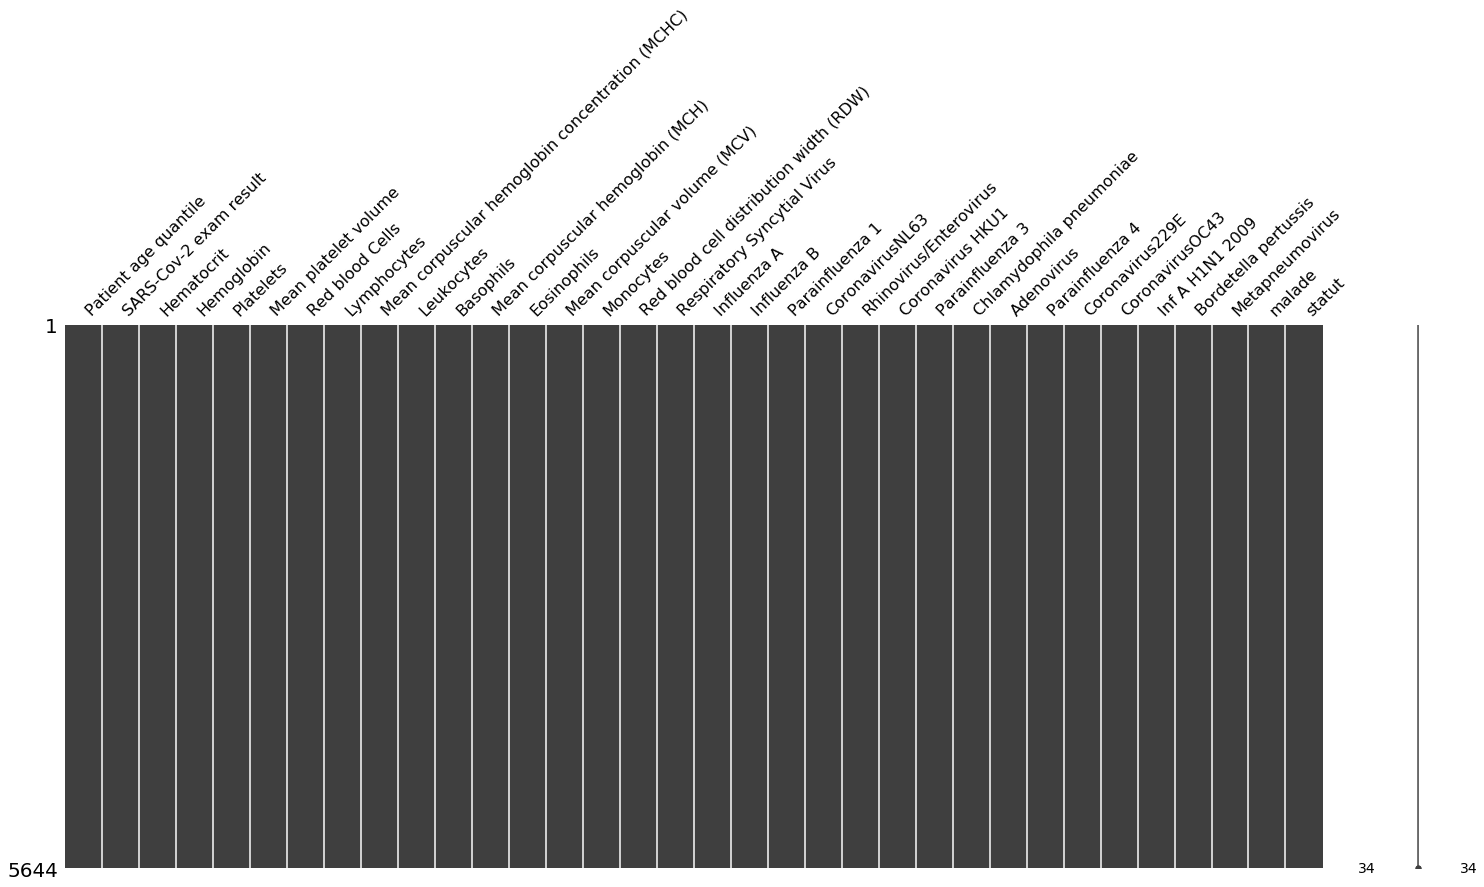

In [108]:
msno.matrix(df)

In [ ]:
df